# Import

In [0]:
import string
from itertools import chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from pyspark.ml.feature import *
from pyspark.ml.feature import Tokenizer
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import sparknlp
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

spark = sparknlp.start()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Helper Functions

In [0]:
# HELPER FUNCTIONS
def cleanup_text(text):
    # clean up text data by removing stopwords, punctuation, and lemmatizing words
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.lower() not in stop_words]  
    words = [word for word in words if word not in string.punctuation]   
    words = [lemmatizer.lemmatize(word, pos='v') for word in words] 
    cleaned_text = " ".join(words)
    return cleaned_text

from pyspark.sql.functions import col, size
def add_features(companies):
    # creates new columns based on existing columns to provide additional information
    companies = companies.withColumn('number_of_similar_companies', size(col('similar')))
    companies = companies.withColumn('number_of_locations', size(col('formatted_locations')))
    return companies

def fill_missing_values(companies, features):
    #  fills missing values in the specified columns. For numeric columns, missing values
    # are filled with 0, and for label columns, missing values are filled with 'none'
    for column in features:
        if column in ['number_of_similar_companies', 'employees_in_linkedin', 'followers']:
            companies = companies.withColumn(f'{column}', when(companies[column].isNull(), -1).otherwise(companies[column]))
        else:
            companies = companies.withColumn(f'{column}', when(companies[column].isNull(), 'none').otherwise(companies[column]))
    return companies

def feature_to_oneHotEncoder(companies, feature):
    # convert a categorical feature to one-hot encoded vectors
    string_indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_index")
    one_hot_encoder = OneHotEncoder(inputCol=f"{feature}_index", outputCol=f"{feature}_feature")
    pipeline = Pipeline(stages=[string_indexer, one_hot_encoder])
    companies = pipeline.fit(companies).transform(companies)
    return companies

def category_to_index(companies, feature, dict_index):
    # convert a categorical feature to indexed values
    mapping_expr = create_map([lit(x) for x in chain(*dict_index.items())])
    if feature == 'popularity_category':
        companies = companies.withColumn(f"label", mapping_expr[col(feature)])
    else:
        companies = companies.withColumn(f"{feature}_feature", mapping_expr[col(feature)])
    return companies

def create_word2vec(companies, text_column):
    # create Word2Vec embeddings for a text column
    cleanup_text_udf = udf(cleanup_text)
    punctuation_pattern = r'[^\w\s]'
    companies = companies.withColumn(f'cleaned_{text_column}', F.regexp_replace(col(text_column), punctuation_pattern, ""))
    companies = companies.withColumn(f'cleaned_{text_column}', cleanup_text_udf(col(f'cleaned_{text_column}')))
    # tokenization
    tokenizer = Tokenizer(inputCol=f'cleaned_{text_column}', outputCol=f"{text_column}_tokens")
    companies = tokenizer.transform(companies)
    # learn a Word2Vec model from the tokenized words
    k = 10
    word2vec = Word2Vec(vectorSize=k, minCount=1, inputCol=f"{text_column}_tokens", outputCol=f"{text_column}_feature")
    word2vec_model = word2vec.fit(companies)
    # transform the tokenized words into word vectors
    companies = word2vec_model.transform(companies)
    return companies

def convert_to_label(companies, label):
    # convert a label column to numeric indices
    indexer = StringIndexer(inputCol=label, outputCol=f"label")
    companies = indexer.fit(companies).transform(companies)
    return companies

from pyspark.sql.functions import lit, create_map
def index_to_category(companies, feature, output_col, dict_index):
    # Create a mapping expression to convert indexed values to strings
    dict_index = {v: k for k, v in dict_index.items()}
    reverse_mapping_expr = create_map([lit(v) for v in chain(*dict_index.items())])
    companies = companies.withColumn(output_col, reverse_mapping_expr[col(feature)])
    return companies

from pyspark.sql.functions import col, when
def show_null_precentage(companies, fetures):
    #display the percentage of null values in specified columns
    null_counts = companies.select([sum(col(column).isNull().cast("int")).alias(column) for column in fetures])
    total_rows = companies.count()
    null_percentage = null_counts.select([(col(column) / total_rows * 100).alias(column + "_null_percentage") for column in fetures])
    null_percentage.display()

def embedding_text_features(train_data, test_data, text_features):
    # embedding text columns and converting the resulting array of embeddings into dense vectors
    for feature in text_features:
        # Create a DocumentAssembler for the current feature
        document = DocumentAssembler() \
            .setInputCol(feature) \
            .setOutputCol("document")

        embeddings = BertSentenceEmbeddings.pretrained("sent_small_bert_L2_128") \
            .setInputCols(["document"]) \
            .setOutputCol("sentence_embeddings")\
            .setCaseSensitive(True) \
            .setMaxSentenceLength(128)

        pipeline = Pipeline(stages=[document,
                                    embeddings])

        transformed_df = pipeline.fit(train_data).transform(test_data)

        # Join the transformed DataFrame with the original DataFrame using the row_id column
        test_data = test_data.join(transformed_df.select("id", f"sentence_embeddings"), on="id", how="left")
        test_data = test_data.withColumnRenamed("sentence_embeddings", f"{feature}_test")

        # Define a function to convert array to DenseVector
        def array_to_vector(arr):
            return Vectors.dense(arr)
        # Create a UDF from the function
        array_to_vector_udf = udf(array_to_vector, VectorUDT())

        test_data = test_data.withColumn(f"{feature}_feature", flatten(expr(f"transform({feature}_test.embeddings, x -> x)")))
        test_data = test_data.withColumn(f"{feature}_feature", array_to_vector_udf(col(f"{feature}_feature")))

    return test_data 

def create_city_state_mapping(companies):
    companies = companies.withColumn("city", when(companies["headquarters"].isNull(), "other").otherwise(split("headquarters", ",")[0]))
    companies = companies.withColumn("state", when(companies["headquarters"].isNull(), "other").otherwise(split("headquarters", ",")[1]))
    companies = companies.withColumn("state", when(companies["state"].isNull(), "other").otherwise(companies["state"]))

    # Count occurrences of each city and state
    city_counts = companies.groupBy("city").count().alias("city_counts")
    state_counts = companies.groupBy("state").count().alias("state_counts")

    # Filter out cities and states appearing less than 5 times
    city_filtered = city_counts.filter(city_counts["count"] >= 5)
    state_filtered = state_counts.filter(state_counts["count"] >= 2)

    # Create a set of cities and states to replace with "other"
    city_set = set(city_filtered.select("city").rdd.flatMap(lambda x: x).collect())
    state_set = set(state_filtered.select("state").rdd.flatMap(lambda x: x).collect())

    # Replace cities and states not in the set with "other"
    companies = companies.withColumn("filtered_city", when(companies["city"].isin(city_set), companies["city"]).otherwise(lit("other"))) \
                         .withColumn("filtered_state", when(companies["state"].isin(state_set), companies["state"]).otherwise(lit("other")))

    unique_cities = companies.select("filtered_city").distinct().rdd.map(lambda x: x[0]).collect()
    city_dict = {city: index for index, city in enumerate(unique_cities)}

    unique_states = companies.select("filtered_state").distinct().rdd.map(lambda x: x[0]).collect()
    states_dict = {state: index for index, state in enumerate(unique_states)}

    cities = udf(lambda x: city_dict[x])
    states = udf(lambda x: states_dict[x])

    return companies, city_set, state_set, cities, states

def create_city_state_indices(companies, city_set, state_set, cities, states, is_test=False):
    if is_test:
        companies = companies.withColumn("city", when(companies["headquarters"].isNull(), "other").otherwise(split("headquarters", ",")[0]))
        companies = companies.withColumn("state", when(companies["headquarters"].isNull(), "other").otherwise(split("headquarters", ",")[1]))
        companies = companies.withColumn("state", when(companies["state"].isNull(), "other").otherwise(companies["state"]))

        # Replace cities and states not in the set with "other"
        companies = companies.withColumn("filtered_city", when(companies["city"].isin(city_set), companies["city"]).otherwise(lit("other"))) \
                            .withColumn("filtered_state", when(companies["state"].isin(state_set), companies["state"]).otherwise(lit("other")))

    # Create indexes of city and state to one hot vector
    companies = companies.withColumn("city_index", cities(col('filtered_city'))) \
                         .withColumn("state_index", states(col('filtered_state'))) \
                                
    companies = companies.withColumn('city_index', col('city_index').cast('int'))
    companies = companies.withColumn('state_index', col('state_index').cast('int'))
    return companies

def create_city_state_one_hot(old_companies, new_companies):
    encoder = OneHotEncoder(inputCol='city_index', outputCol='city_feature', dropLast=False)
    new_companies = encoder.fit(old_companies.drop('city_feature')).transform(new_companies)

    encoder = OneHotEncoder(inputCol='state_index', outputCol='state_feature', dropLast=False)
    new_companies = encoder.fit(old_companies.drop('state_feature')).transform(new_companies)

    return new_companies

def create_one_hot_from_dict(companies, feature_name, index_dict):
    indices = udf(lambda x: index_dict[x])
    companies = companies.withColumn(f"{feature_name}_index", indices(col(feature_name)))               
    companies = companies.withColumn(f"{feature_name}_index", col(f"{feature_name}_index").cast('int'))
    encoder = OneHotEncoder(inputCol=f"{feature_name}_index", outputCol=f"{feature_name}_feature", dropLast=False)
    companies = encoder.fit(companies).transform(companies)
    return companies


In [0]:
company_size_dict = {'none': 0,
                     '1 employee': 1,
                     '2-10 employees': 2,
                     '11-50 employees': 3,
                     '51-200 employees': 4,
                     '201-500 employees': 5,
                     '501-1,000 employees': 6,
                     '1,001-5,000 employees': 7,
                     '5,001-10,000 employees': 8,
                     '10,001+ employees': 9
                     }

meta_industries_dict = {'Manufacturing': 0,
            'Financial and Investment': 1,
            'Services': 2,
            'Miscellaneous': 3,
            'Healthcare and Medical': 4,
            'Technology': 5,
            'Retail and Consumer Goods': 6,
            'Education and Training': 7,
            'Government and Public Policy': 8,
            'Transportation and Logistics': 9,
            'Real Estate and Construction': 10,
            'Media and Entertainment': 11
            } 

organization_type_dict = {'Privately Held': 0,
                          'Self-Owned': 1,
                          'Nonprofit': 2,
                          'Partnership': 3,
                          'Self-Employed': 4,
                          'Educational': 5,
                          'Public Company': 6,
                          'Government Agency': 7,
                          'none': 8
                        }

meta_industries_12 = {
    'Furniture and Home Furnishings Manufacturing': 'Manufacturing',
    'Investment Banking': 'Financial and Investment',
    'Architecture and Planning': 'Services',
    'Wholesale': 'Services',
    'Travel Arrangements': 'Services',
    'Ranching': 'Miscellaneous',
    'Hospitals and Health Care': 'Healthcare and Medical',
    'Book and Periodical Publishing': 'Services',
    'Printing Services': 'Services',
    'Professional Training and Coaching': 'Services',
    'Computers and Electronics Manufacturing': 'Manufacturing',
    'Shipbuilding': 'Manufacturing',
    'Public Policy Offices': 'Government and Public Policy',
    'Software Development': 'Technology',
    'Outsourcing and Offshoring Consulting': 'Services',
    'Retail Groceries': 'Retail and Consumer Goods',
    'Education Administration Programs': 'Education and Training',
    'Plastics Manufacturing': 'Manufacturing',
    'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
    'Computer Networking Products': 'Technology',
    'Events Services': 'Services',
    'Information Services': 'Services',
    'Food and Beverage Services': 'Services',
    'Semiconductor Manufacturing': 'Manufacturing',
    'Business Consulting and Services': 'Services',
    'Insurance': 'Services',
    'Financial Services': 'Services',
    'Wireless Services': 'Services',
    'Computer Hardware Manufacturing': 'Technology',
    'Public Safety': 'Services',
    'Maritime Transportation': 'Transportation and Logistics',
    'Tobacco Manufacturing': 'Manufacturing',
    'Writing and Editing': 'Services',
    'Veterinary Services': 'Services',
    'Staffing and Recruiting': 'Services',
    'Accounting': 'Services',
    'International Affairs': 'Government and Public Policy',
    'Spectator Sports': 'Miscellaneous',
    'Glass, Ceramics and Concrete Manufacturing': 'Manufacturing',
    'Chemical Manufacturing': 'Manufacturing',
    'Mining': 'Miscellaneous',
    'E-Learning Providers': 'Technology',
    'Security and Investigations': 'Services',
    'Translation and Localization': 'Services',
    'Automation Machinery Manufacturing': 'Technology',
    'Computer and Network Security': 'Technology',
    'Political Organizations': 'Government and Public Policy',
    'Environmental Services': 'Government and Public Policy',
    'Oil and Gas': 'Miscellaneous',
    'Real Estate': 'Real Estate and Construction',
    'Think Tanks': 'Government and Public Policy',
    'Executive Offices': 'Miscellaneous',
    'Law Practice': 'Services',
    'Nanotechnology Research': 'Miscellaneous',
    'International Trade and Development': 'Government and Public Policy',
    'Personal Care Product Manufacturing': 'Manufacturing',
    'Philanthropic Fundraising Services': 'Services',
    'Entertainment Providers': 'Media and Entertainment',
    'Market Research': 'Media and Entertainment',
    'Movies, Videos, and Sound': 'Media and Entertainment',
    'Sporting Goods Manufacturing': 'Manufacturing',
    'Graphic Design': 'Services',
    'Technology, Information and Internet': 'Technology',
    'IT Services and IT Consulting': 'Technology',
    'Retail Office Equipment': 'Retail and Consumer Goods',
    'Wholesale Import and Export': 'Services',
    'Capital Markets': 'Financial and Investment',
    'Law Enforcement': 'Services',
    'Freight and Package Transportation': 'Transportation and Logistics',
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Non-profit Organizations': 'Miscellaneous',
    'Retail Art Supplies': 'Retail and Consumer Goods',
    'Animation and Post-production': 'Media and Entertainment',
    'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
    'Aviation and Aerospace Component Manufacturing': 'Transportation and Logistics',
    'Fundraising': 'Financial and Investment',
    'Railroad Equipment Manufacturing': 'Transportation and Logistics',
    'Construction': 'Real Estate and Construction',
    'Investment Management': 'Financial and Investment',
    'Utilities': 'Miscellaneous',
    'Retail Luxury Goods and Jewelry': 'Retail and Consumer Goods',
    'Warehousing and Storage': 'Transportation and Logistics',
    'Media Production': 'Media and Entertainment',
    'Gambling Facilities and Casinos': 'Media and Entertainment',
    'Defense and Space Manufacturing': 'Manufacturing',
    'Facilities Services': 'Services',
    'Government Relations Services': 'Government and Public Policy',
    'Advertising Services': 'Media and Entertainment',
    'Paper and Forest Product Manufacturing': 'Manufacturing',
    'Packaging and Containers Manufacturing': 'Manufacturing',
    'Telecommunications': 'Technology',
    'Medical Equipment Manufacturing': 'Healthcare and Medical',
    'Beverage Manufacturing': 'Manufacturing',
    'Restaurants': 'Retail and Consumer Goods',
    'Leasing Non-residential Real Estate': 'Real Estate and Construction',
    'Newspaper Publishing': 'Media and Entertainment',
    'Armed Forces': 'Miscellaneous',
    'Appliances, Electrical, and Electronics Manufacturing': 'Manufacturing',
    'Hospitality': 'Services',
    'Pharmaceutical Manufacturing': 'Healthcare and Medical',
    'Research Services': 'Services',
    'Retail Apparel and Fashion': 'Retail and Consumer Goods',
    'Photography': 'Media and Entertainment',
    'Wellness and Fitness Services': 'Services',
    'Truck Transportation': 'Transportation and Logistics',
    'Consumer Services': 'Services',
    'Wholesale Building Materials': 'Services',
    'Human Resources Services': 'Services',
    'Airlines and Aviation': 'Transportation and Logistics',
    'Machinery Manufacturing': 'Manufacturing',
    'Individual and Family Services': 'Services',
    'Motor Vehicle Manufacturing': 'Manufacturing',
    'Performing Arts': 'Media and Entertainment',
    'Museums, Historical Sites, and Zoos': 'Media and Entertainment',
    'Broadcast Media Production and Distribution': 'Media and Entertainment',
    'Banking': 'Financial and Investment',
    'Recreational Facilities': 'Miscellaneous',
    'Government Administration': 'Government and Public Policy',
    'Public Relations and Communications Services': 'Media and Entertainment',
    'Fisheries': 'Miscellaneous',
    'Medical Practices': 'Healthcare and Medical',
    'Religious Institutions': 'Miscellaneous',
    'Online Audio and Video Media': 'Media and Entertainment',
    'Artists and Writers': 'Miscellaneous',
    'Biotechnology Research': 'Healthcare and Medical',
    'Legal Services': 'Services',
    'Retail': 'Retail and Consumer Goods',
    'Civil Engineering': 'Services',
    'Libraries': 'Miscellaneous',
    'Alternative Dispute Resolution': 'Miscellaneous',
    'Manufacturing': 'Miscellaneous',
    'Design Services': 'Services',
    'Dairy Product Manufacturing': 'Manufacturing',
    'Higher Education': 'Education and Training',
    'Civic and Social Organizations': 'Miscellaneous',
    'Textile Manufacturing': 'Manufacturing',
    'Venture Capital and Private Equity Principals': 'Financial and Investment',
    'Mental Health Care': 'Healthcare and Medical',
    'Musicians': 'Media and Entertainment',
    'Farming': 'Miscellaneous',
    'Computer Games': 'Media and Entertainment',
    'Strategic Management Services': 'Services',
    'Food and Beverage Manufacturing': 'Manufacturing',
    'Primary and Secondary Education': 'Education and Training',
    'Alternative Medicine': 'Healthcare and Medical',
    'Legislative Offices': 'Services',
    'Administration of Justice': 'Services',
    'Mobile Gaming Apps': 'Media and Entertainment'
}

# Upload new & old companies trend and merge the linkedin companies data

In [0]:
companies = spark.read.parquet('/linkedin/companies')

# upload companies trend
old_companies_trend_df = pd.read_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/final_old_companies_trend_preprocess")
new_companies_trend_df = pd.read_csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/final_new_companies_trend_preprocess")
old_companies = spark.createDataFrame(old_companies_trend_df)
new_companies = spark.createDataFrame(new_companies_trend_df)

# merge with linkedin companies data
old_companies = companies.join(old_companies, 'name', 'inner')
new_companies = companies.join(new_companies, 'name', 'inner')

# Filter companies that contain & in thier name
old_companies = old_companies.filter(~col("search_name").contains("&"))
new_companies = new_companies.filter(~col("search_name").contains("&"))

# filter old & new companies according to our definition
old_companies = old_companies.filter(col('founded') >= '1900').filter(col('founded') < '2020')
new_companies = new_companies.filter(col('founded') >= '2020').filter(col('founded') < '2025')

# add meta_industry column
meta_industry = udf(lambda x: meta_industries_12[x] )

old_companies = old_companies.filter(old_companies.industries.isNotNull())
old_companies = old_companies.withColumn('meta_industry', meta_industry(col('industries')))

new_companies = new_companies.filter(new_companies.industries.isNotNull())
new_companies = new_companies.withColumn('meta_industry', meta_industry(col('industries')))

# Stability Features

In [0]:
# create list of all the relevant companies that we want to extract features
old_companies_id = old_companies.select('id').distinct().rdd.map(lambda x: x[0]).collect()
new_companies_id = new_companies.select('id').distinct().rdd.map(lambda x: x[0]).collect()
total_copmpanies_list = old_companies_id + new_companies_id

In [0]:
companies = spark.read.parquet('/linkedin/companies')
companies = companies.filter(col('id').isin(total_copmpanies_list))

# add meta_industry column
meta_industry = udf(lambda x: meta_industries_12[x] )
companies = companies.filter(companies.industries.isNotNull())
companies = companies.withColumn('meta_industry', meta_industry(col('industries')))

# fill missing values
old_companies = fill_missing_values(old_companies, ['company_size', 'organization_type', 'about', 'slogan', 'specialties'])

# company_size feature
old_companies = category_to_index(old_companies, 'company_size', company_size_dict)

# organization_type feature
old_companies = create_one_hot_from_dict(old_companies, 'organization_type', organization_type_dict)

# add meta_industry column & feature
meta_industry = udf(lambda x: meta_industries_12[x] )
companies = companies.filter(companies.industries.isNotNull())
companies = companies.withColumn('meta_industry', meta_industry(col('industries')))
companies = create_one_hot_from_dict(companies, 'meta_industry', meta_industries_dict)

# state feature
companies, city_set, state_set, cities, states = create_city_state_mapping(companies)
companies = create_city_state_indices(companies, city_set, state_set, cities, states, is_test=False)
companies = create_city_state_one_hot(companies, companies)
companies = companies.drop('city_feature')

# text ('about', 'slogan', 'specialties') features
companies = embedding_text_features(companies, companies, ['about', 'slogan', 'specialties'])

# create feature df after pre process   
features_columns = [col for col in companies.columns if 'feature' in col]
features_df = companies.select(features_columns + ['id'])

# Assemble numeric features into a vector
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
features_df = assembler.transform(features_df)

features_df = features_df.select('id', 'features')

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


# Cosine similarity between old and new companies

In [0]:
old_companies = old_companies.join(features_df, "id", 'inner')
new_companies = new_companies.join(features_df, "id", 'inner')
old_company = old_companies.withColumnRenamed("id", "old_company_id").withColumnRenamed("features", "old_features").select('old_company_id','old_features')
new_company = new_companies.withColumnRenamed("id", "new_company_id").withColumnRenamed("features", "new_features").select('new_company_id','new_features')
old_vs_new_similarity_df = old_company.crossJoin(new_company)

def cosine_similarity(vec1, vec2):
    dot_product = float(vec1.dot(vec2))
    norm_vec1 = float(vec1.norm(2))
    norm_vec2 = float(vec2.norm(2))
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity
cosine_similarity_udf = F.udf(cosine_similarity, FloatType())

old_vs_new_similarity_df = old_vs_new_similarity_df.withColumn("similarity_score", cosine_similarity_udf("old_features", "new_features"))
old_vs_new_similarity_df.orderBy('similarity_score', ascending=False).select('old_company_id', 'new_company_id', 'similarity_score').limit(50).display()

old_company_id,new_company_id,similarity_score
koecreate,traaaaaaaaaaaaa,0.99587995
executive-education-tulane-universty,traaaaaaaaaaaaa,0.9950943
regionalpavementmaintenance,traaaaaaaaaaaaa,0.99480826
scarlett-protective-inc-,traaaaaaaaaaaaa,0.9936825
alphapex-llc,traaaaaaaaaaaaa,0.99290925
proterra-ag,rasss,0.98869455
iscar-metals,systematic-group-of-companies,0.9874798
corporatecareit,supplier-community-connect,0.98604745
unemployed-philosophers-inc.,smartz-inc,0.9847355
drinktap,smartz-inc,0.9845134


# Find the similar old company to each new company and assign a stability score accordingly.

In [0]:
max_similarity_df = old_vs_new_similarity_df.groupBy('old_company_id').agg(max('similarity_score').alias('max_similarity_score'))
max_similarity_df = max_similarity_df.withColumnRenamed("old_company_id", "id")
similarity_companies = max_similarity_df.join(old_vs_new_similarity_df,
                                               (old_vs_new_similarity_df['old_company_id'] == max_similarity_df['id']) &
                                               (old_vs_new_similarity_df['similarity_score'] == max_similarity_df['max_similarity_score']), 'inner').select('old_company_id', 'new_company_id', 'similarity_score')
 
similarity_companies = similarity_companies.join(old_companies.select('id', 'stability'), old_companies['id'] == similarity_companies['old_company_id'], 'inner')
similarity_companies = similarity_companies.groupBy('new_company_id').agg(mean('stability').alias('predicted_stability')).select('new_company_id', 'predicted_stability')
new_companies = new_companies.join(similarity_companies, new_companies['id'] == similarity_companies['new_company_id'], 'inner')

new_companies.select('id', 'predicted_stability').display()

id,predicted_stability
redwood-services-llc,9.434979370564726
bunnystudio,17.476356970195607
splitappstore,12.39546350115574
test-banks,9.235585630795063
workshoplocal,18.56399241812415
eucalyptushealthcare,9.374118441911872
shopclairvaux,11.912716406548597
theculturexyz,13.466712399426305
in-the-worx,9.964645495362275
vita-health,15.63170861722506


In [0]:
new_companies.select('id', 'predicted_stability').write.csv("/dbfs/FileStore/shared_uploads/omriitzhaki@campus.technion.ac.il/predicted_stability_df", header=True)

# Similarity Scores Distribution

In [0]:
similarity_score_df = old_vs_new_similarity_df.select('similarity_score').toPandas()

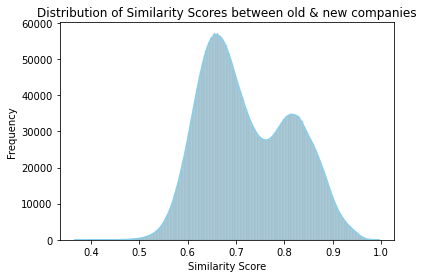

In [0]:
sns.histplot(data=similarity_score_df, x='similarity_score', kde=True, color='skyblue')
plt.title('Distribution of Similarity Scores between old & new companies')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()